In [8]:
pip install scikit-learn==1.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 49.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.


In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor,IsolationForest
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import shap
from sklearn.decomposition import PCA

Handle Missing Values

In [3]:

data = pd.read_csv('orig_all_1s_numeric_final_merged_synthetic_respondents.csv', encoding='latin1')

# 1.1 Fill missing values in multi-select questions with 0
multi_select_cols = [
    'q5_1', 'q5_2', 'q5_3', 'q5_4', 'q5_5',
    'q8_1', 'q8_2', 'q8_3', 'q8_4', 'q8_5', 'q8_6',
    'q9_1', 'q9_2', 'q9_3', 'q9_4', 'q9_5', 'q9_6'
]
data[multi_select_cols] = data[multi_select_cols].fillna(0)

# 1.2 Fill q6_5 based on missing values in q6_1 to q6_4
q6_cols = ['q6_1', 'q6_2', 'q6_3', 'q6_4']
all_values = {1, 2, 3, 4, 5}

def fill_q6_5(row):
    existing_values = {row[q] for q in q6_cols if not pd.isna(row[q])}
    missing_values = all_values - existing_values
    return missing_values.pop() if len(missing_values) == 1 else np.nan

data['q6_5'] = data.apply(lambda row: fill_q6_5(row) if pd.isna(row['q6_5']) else row['q6_5'], axis=1)

# 1.3 Fill specific columns with 'No Response'
response_cols = ['q12', 'q13', 'q17', 'q19', 'q24', 'q27', 'q31', 'q35']
data[response_cols] = data[response_cols].fillna('No Response')

for col in response_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert non-numeric to NaN

# 1.4 Handle pairwise deletion and other preprocessing
target_column = 'q21'  # Assuming 'q21' is the target column
if target_column in data.columns:
    y = data[target_column]
    X = data.drop(columns=[target_column])
else:
    y = None
    X = data

if 'respondent_id' in X.columns:
    X = X.drop(columns=['respondent_id'])

if y is not None:
    valid_idx = y.notna()
    X = X[valid_idx]
    y = y[valid_idx]

# Exclude columns with >90% missing data
missing_threshold = 0.90
cols_to_drop = X.columns[X.isnull().mean() > missing_threshold]
X = X.drop(columns=cols_to_drop)

# Fill remaining missing values in logical skips with a neutral value
X = X.fillna(-1)

print(f"Shape after missing value handling: Features = {X.shape}, Target = {y.shape if y is not None else 'N/A'}")

Shape after missing value handling: Features = (1000, 72), Target = (1000,)


In [4]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [5]:
 # Step 3: Dimensionality Reduction using PCA
 pca = PCA(n_components=0.95)
 X_pca = pd.DataFrame(pca.fit_transform(X_scaled), columns=[f'PC{i+1}' for i in range(pca.n_components_)])

 print(f"PCA reduced dataset shape: {X_pca.shape}")


PCA reduced dataset shape: (1000, 64)


In [6]:
 # Step 4: Split the Data
 X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


Model Training

In [7]:
models = {
     "Random Forest": RandomForestRegressor(random_state=42),
     "Elastic Net": ElasticNet(random_state=42),
     "XGBoost": xgb.XGBRegressor(random_state=42),
     "LightGBM": lgb.LGBMRegressor(random_state=42),
}

 param_grids = {
     "Random Forest": {
         'n_estimators': [50, 100, 200],
         'max_depth': [None, 10, 20],
         'min_samples_split': [2, 5, 10]
     },
    "Elastic Net": {
        'alpha': [0.01, 0.1, 1.0],
        'l1_ratio': [0.2, 0.5, 0.8]
    },
     "XGBoost": {
         'n_estimators': [50, 100, 200],
         'learning_rate': [0.01, 0.1, 0.2],
         'max_depth': [3, 5, 7]
     },
     "LightGBM": {
         'n_estimators': [50, 100, 200],
         'learning_rate': [0.01, 0.1, 0.2],
         'num_leaves': [20, 31, 50]
     }
 }

 tuned_results = {}
for name, model in models.items():
     print(f"Tuning hyperparameters for {name}...")
     grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
     grid_search.fit(X_train, y_train)
     best_model = grid_search.best_estimator_
     best_params = grid_search.best_params_

     preds = best_model.predict(X_test)
     tuned_results[name] = {
         "Best Params": best_model,
         "MAE": mean_absolute_error(y_test, preds),
         "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
         "R2": r2_score(y_test, preds)
     }
     print(f"Best Parameters for {name}: {best_params}")

 # Weighted Average Blender
 weights = {
     "Random Forest": 0.3,
     "Elastic Net": 0.2,
     "XGBoost": 0.3,
     "LightGBM": 0.2
 }

 blended_preds = sum(weights[name] * tuned_results[name]["Best Params"].predict(X_test) for name in weights.keys())
 blender_results = {
     "MAE": mean_absolute_error(y_test, blended_preds),
     "RMSE": np.sqrt(mean_squared_error(y_test, blended_preds)),
     "R2": r2_score(y_test, blended_preds)
 }

 # Display model evaluation metrics
 print("\nModel Results:")
 for model_name, metrics in tuned_results.items():
     print(f"{model_name}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R2={metrics['R2']:.4f}")
     print(f"Weighted Blender: MAE={blender_results['MAE']:.4f}, RMSE={blender_results['RMSE']:.4f}, R2={blender_results['R2']:.4f}")


Tuning hyperparameters for Random Forest...
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Tuning hyperparameters for Elastic Net...
Best Parameters for Elastic Net: {'alpha': 1.0, 'l1_ratio': 0.5}
Tuning hyperparameters for XGBoost...
Best Parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Tuning hyperparameters for LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 64
[LightGBM] [Info] Start training from score 2.976250
Best Parameters for LightGBM: {'learning_rate': 0.01, 'n_estimators': 50, 'num_leaves': 20}

Model Results:
Random Forest: MAE=1.3238, RMSE=1.5049, R2=0.0045
Weighted Blender: MAE=1.3114, RMSE=1.5006, R2=0.0102
Elastic Net: MAE=1.3090, RMSE=

Feature Importance Plot

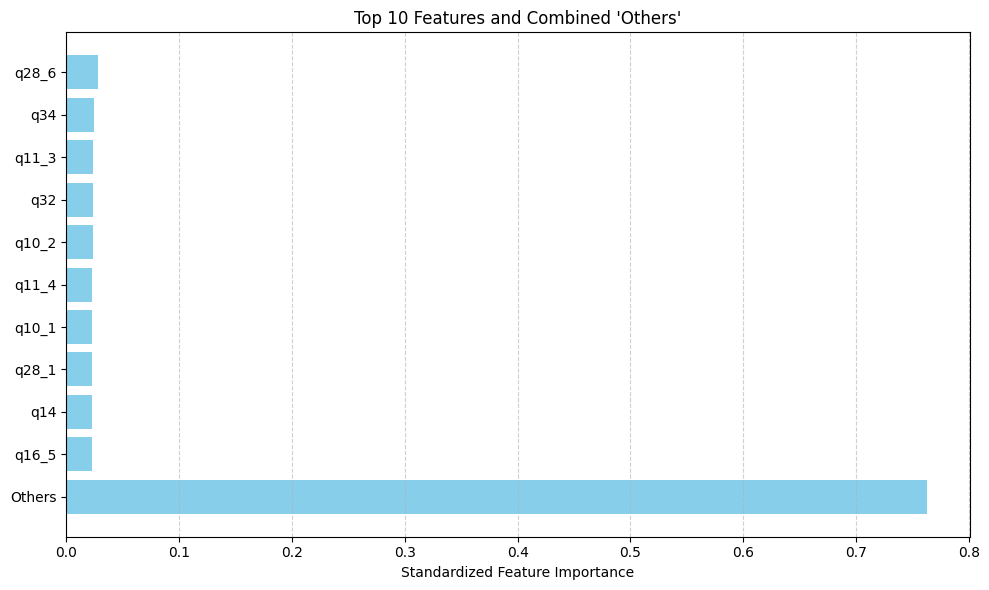

In [9]:
 model_rf = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=None)
 model_rf.fit(X_scaled, y)
 feature_importances = model_rf.feature_importances_
 normalized_importances = feature_importances / feature_importances.sum()

 sorted_indices = np.argsort(normalized_importances)[::-1]
 sorted_features = X.columns[sorted_indices]
 sorted_importances = normalized_importances[sorted_indices]

 top_10_features = sorted_features[:10]
 top_10_importances = sorted_importances[:10]
 combined_importance = sorted_importances[10:].sum()

 plot_features = list(top_10_features) + ["Others"]
 plot_importances = list(top_10_importances) + [combined_importance]

 # Plot the horizontal bar chart
 plt.figure(figsize=(10, 6))
 plt.barh(plot_features[::-1], plot_importances[::-1], color='skyblue')
 plt.xlabel("Standardized Feature Importance")
 plt.title("Top 10 Features and Combined 'Others'")
 plt.grid(axis='x', linestyle='--', alpha=0.6)
 plt.tight_layout()
 plt.show()

SHAP Value Plot

Generating SHAP summary plot...


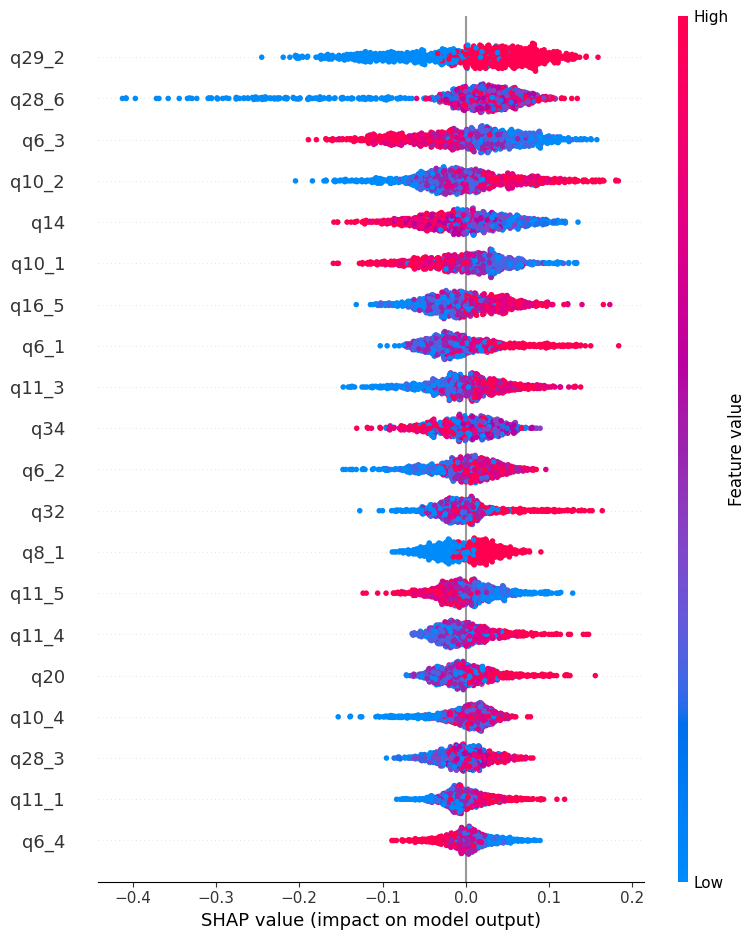

Generating SHAP dependence plot for q28_6...


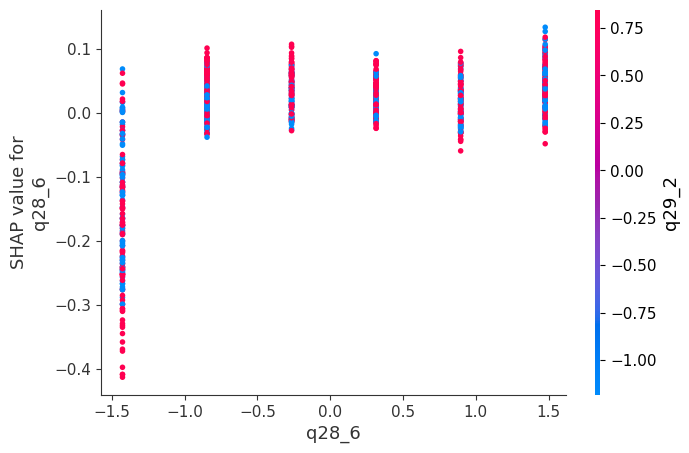

Generating SHAP summary plot...


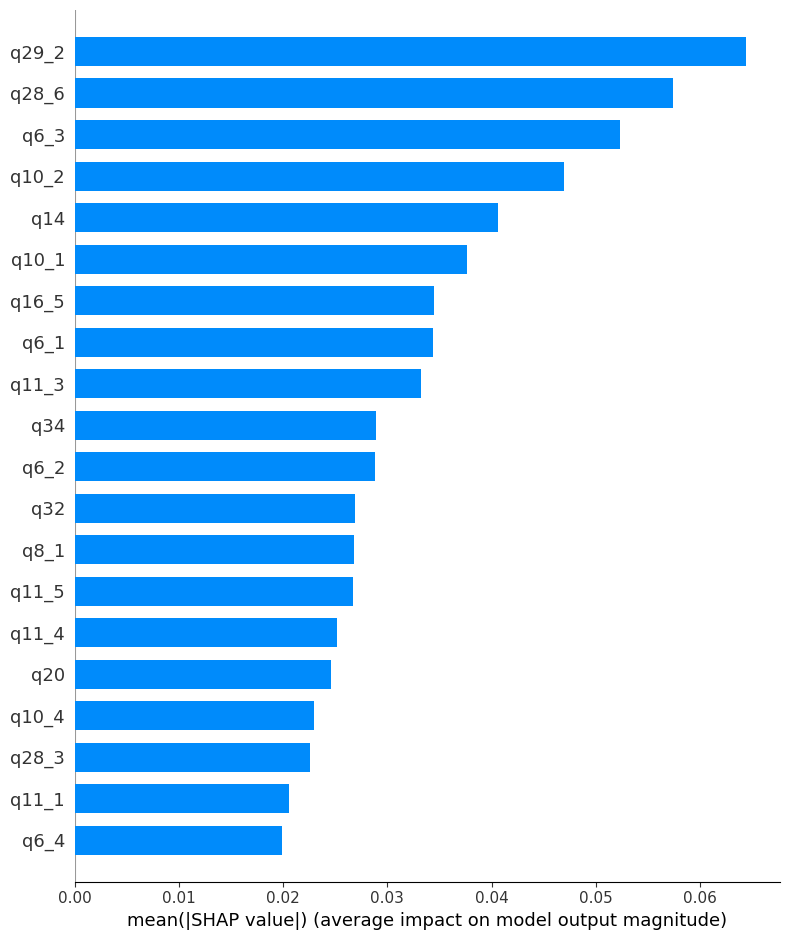

In [14]:
explainer = shap.TreeExplainer(model_rf)


shap_values = explainer.shap_values(X_scaled)

print("Generating SHAP summary plot...")
shap.summary_plot(shap_values, X_scaled, feature_names=X.columns)


most_important_feature = sorted_features[0]
print(f"Generating SHAP dependence plot for {most_important_feature}...")
shap.dependence_plot(most_important_feature, shap_values, X_scaled, feature_names=X.columns)

print("Generating SHAP summary plot...")
shap.summary_plot(shap_values, X_scaled, feature_names=X.columns,plot_type='bar')



Linear Regression Model for Top 10 Features and PCA for others

In [16]:
X_top10 = X_scaled[top_10_features]
X_others = X_scaled.drop(columns=top_10_features)

pca = PCA(n_components=0.95)
X_others_pca = pd.DataFrame(pca.fit_transform(X_others), columns=[f'PC{i+1}' for i in range(pca.n_components_)])

X_combined = pd.concat([X_top10.reset_index(drop=True), X_others_pca.reset_index(drop=True)], axis=1)

X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
     X_combined, y, test_size=0.2, random_state=42
)

linear_model = LinearRegression()
linear_model.fit(X_train_combined, y_train_combined)

 # Evaluate the model
preds_combined = linear_model.predict(X_test_combined)
mae_combined = mean_absolute_error(y_test_combined, preds_combined)
rmse_combined = np.sqrt(mean_squared_error(y_test_combined, preds_combined))
r2_combined = r2_score(y_test_combined, preds_combined)

# Display the results
print("\nLinear Regression with Top 10 Features and PCA Components:")
print(f"MAE: {mae_combined:.4f}")
print(f"RMSE: {rmse_combined:.4f}")
print(f"R2: {r2_combined:.4f}")


Linear Regression with Top 10 Features and PCA Components:
MAE: 1.2931
RMSE: 1.4775
R2: 0.0404


Anomaly Detection

In [26]:
# Model 1: Isolation Forest
iso_forest = IsolationForest(random_state=42, n_estimators=100, contamination='auto')
iso_scores = -iso_forest.fit_predict(X_scaled)

# Model 2: Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
lof_scores = -lof.fit_predict(X_scaled)

# Model 3: One-Class SVM
one_class_svm = OneClassSVM(kernel="rbf", gamma="auto")
svm_scores = -one_class_svm.fit_predict(X_scaled)

# Average the anomaly scores
anomaly_scores = (iso_scores + lof_scores + svm_scores) / 3

X_pca_df = pd.DataFrame(X_pca)

y = pd.DataFrame(y).reset_index(drop=True)

cleaned_data = pd.concat([X_pca_df, y], axis=1)
cleaned_data['anomaly_scores'] = anomaly_scores

# Save the dataset to a CSV file
cleaned_data.to_csv('cleaned_pca_dataset_with_anomaly_scores.csv', index=False)

print("Processed dataset with anomaly scores saved successfully!")

Processed dataset with anomaly scores saved successfully!


Clustering Algorithms

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


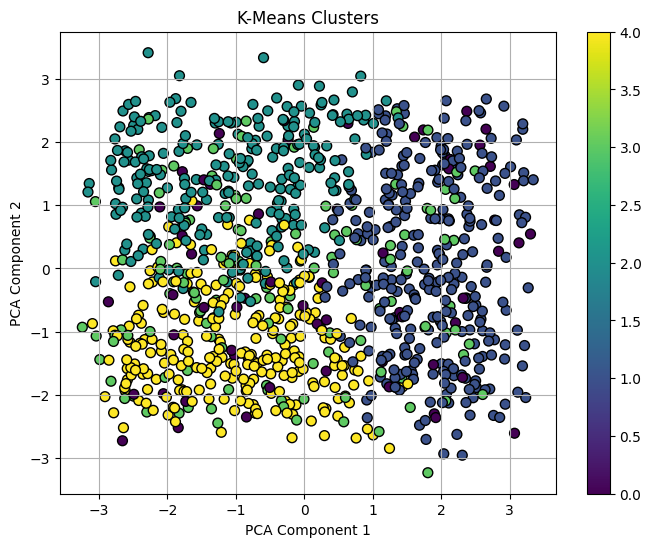

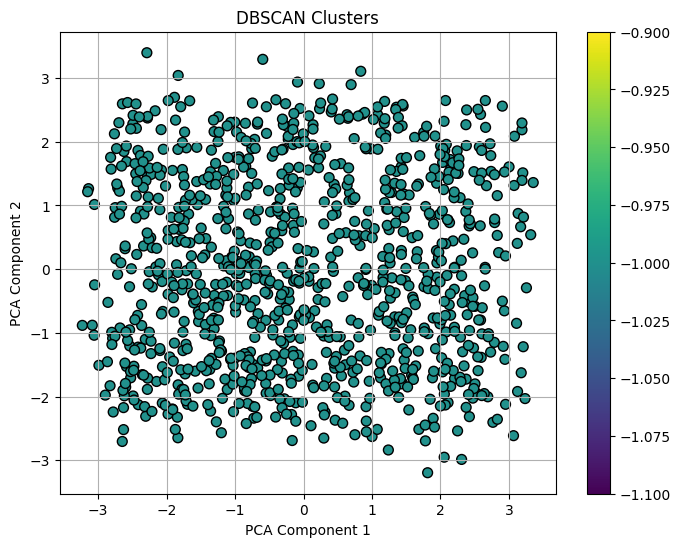

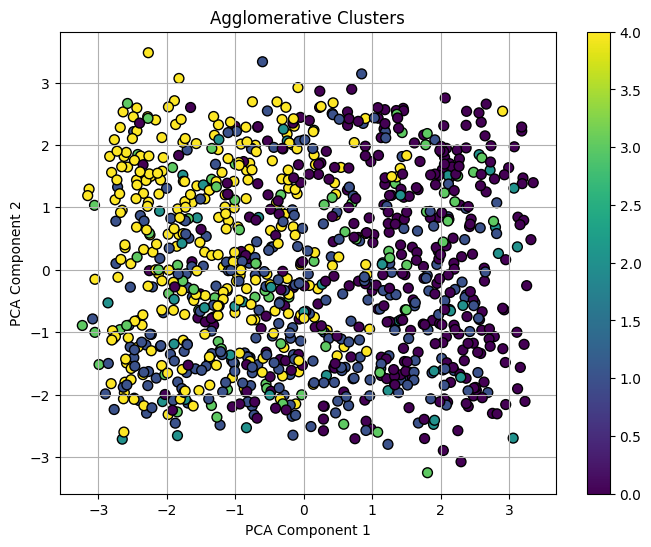

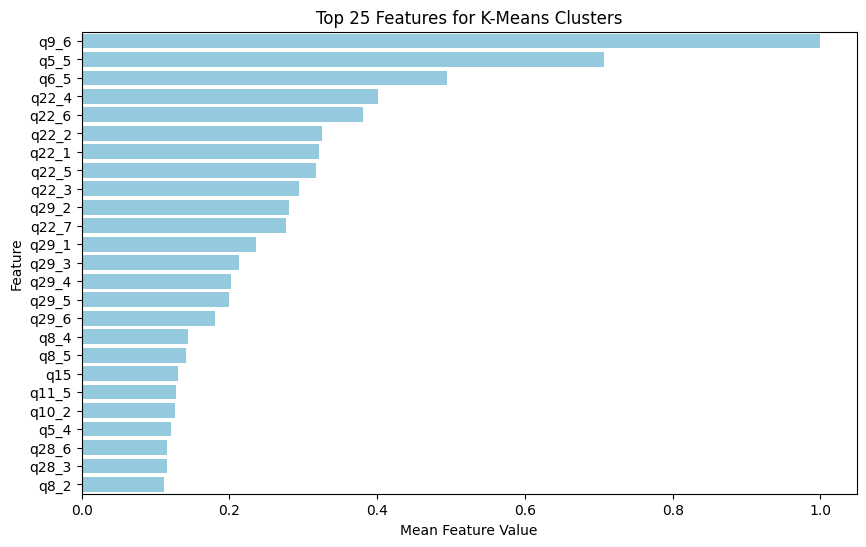

In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=5)
agglo_labels = agglo.fit_predict(X_scaled)

def plot_clusters(X, labels, title="Clusters", ax=None):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X)
    if ax is None:
        plt.figure(figsize=(8, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar()
    plt.grid(True)
    plt.show()

# Plot K-Means Clusters
plot_clusters(X_scaled, kmeans_labels, "K-Means Clusters")

# Plot DBSCAN Clusters
plot_clusters(X_scaled, dbscan_labels, "DBSCAN Clusters")

# Plot Agglomerative Clusters
plot_clusters(X_scaled, agglo_labels, "Agglomerative Clusters")

def cluster_profile(X, labels):
    cluster_profiles = pd.DataFrame(columns=X.columns)
    for cluster in np.unique(labels):
        cluster_data = X[labels == cluster]
        cluster_profiles.loc[cluster] = cluster_data.mean()
    return cluster_profiles

kmeans_profile = cluster_profile(X_scaled, kmeans_labels)
top_25_kmeans = kmeans_profile.abs().mean(axis=0).sort_values(ascending=False).head(25)

# Plot top 25 feature importance for K-Means clusters
plt.figure(figsize=(10, 6))
sns.barplot(x=top_25_kmeans.values, y=top_25_kmeans.index, color='skyblue')  # Use color instead of palette
plt.title("Top 25 Features for K-Means Clusters")
plt.xlabel("Mean Feature Value")
plt.ylabel("Feature")
plt.show()
